In [189]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

In [190]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'endo valid'
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_session_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        sham_before_slow = align_slow(sb, case, fs)
        sham_after_slow = align_slow(sa, case, fs)
        real_before_slow = align_slow(rb, case, fs)
        real_after_slow = align_slow(ra, case, fs)

        # sham_before_slow = sb
        # sham_after_slow = sa
        # real_before_slow = rb
        # real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

In [191]:
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 50]]
# exclude fixation
endo_fast_interval = [1.5, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5, 1.5+1+0.5+0.05+0.2]
#endo_slow_interval = [1.5, 1.5+1+1+0.05+0.2]
exo_fast_interval = [1.5, 1.5+0.033*4+0.5+0.05+0.2]
exo_slow_interval = [1.5, 1.5+0.033*4+0.5+0.05+0.2]
# exo_slow_interval = [1.5, 1.5+0.033*4+1+0.05+0.2]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow]
fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

In [192]:
bp_table = np.zeros((4, 32, 4)) # 4 sessions, 32 channels, 4 frequency bands

for channel in range(32):
    for k, band in enumerate(freq_bands):
        for i in range(4):
            fast_session = fast_sessions[i][channel]
            slow_session = slow_sessions[i][channel]
            tmp = np.empty(())
            for j, data in enumerate([fast_session, slow_session]):
                interval = intervals[j]
                t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
                psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False)
                bp = fe.band_power(psds, freqs, band)
                tmp = np.append(tmp, bp)
            tmp = fe.rm_outlier(tmp, lower_k=3, upper_k=100, verbose=True)
            bp_table[i, channel, k] = np.mean(tmp)


Removed 0 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 0 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 0 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outliers from the data.
Removed 1 outl

In [193]:
# bp_table = np.zeros((4, 2, 32, 4)) # 4 sessions, 32 channels, 4 frequency bands

# for channel in range(32):
#     for k, band in enumerate(freq_bands):
#         for i in range(4):
#             fast_session = fast_sessions[i][channel]
#             slow_session = slow_sessions[i][channel]
#             for j, data in enumerate([fast_session, slow_session]):
#                 interval = intervals[j]
#                 t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
#                 psds, freqs = mne.time_frequency.psd_array_multitaper(data[:,t_start:t_end], fs, fmin=2, fmax=51, verbose=False) # psd(trials, freqs)
#                 bps = fe.band_power(psds, freqs, band)
#                 bp_table[i, j, channel, k] = np.mean(bps)

In [194]:
# band = 0
# fast, slow = bp_table[0,0,:,band], bp_table[0,1,:,band]

# plt.scatter(range(len(fast)), fast, color='blue', label='fast')
# plt.scatter(range(len(slow)), slow, color='red', label='slow')
# plt.title(band)
# plt.legend()
# plt.ylim([0, 7e-8])
# plt.show()

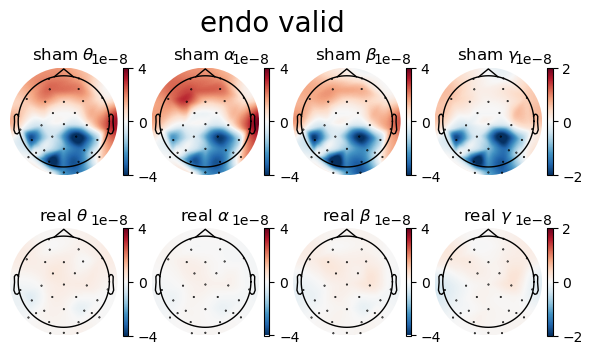

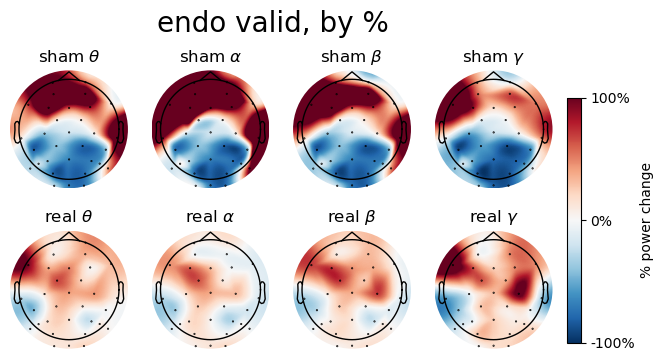

In [199]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

bp_subtracts = np.zeros((2, 32, 4))
bp_subtracts_norm = np.zeros((2, 32, 4))
bp_subtracts[0] = bp_table[1,:,:] - bp_table[0,:,:]
bp_subtracts[1] = bp_table[3,:,:] - bp_table[2,:,:]
bp_subtracts_norm[0] = bp_subtracts[0] / bp_table[0,:,:]
bp_subtracts_norm[1] = bp_subtracts[1] / bp_table[2,:,:]

raw = fe.channel_pos()

band_names = ['$\u03B8$', '$\u03B1$', '$\u03B2$', '$\u03B3$']
group_names = ['sham', 'real']

fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(7, 3.5))
cbar_lim = [(-4e-8, 4e-8), (-4e-8, 4e-8), (-4e-8, 4e-8), (-2e-8, 2e-8)]

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim[k])
        # Add title to each subplot
        ax.set_title(group_name + ' ' + band_name)

        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_ticks([cbar_lim[k][0], 0, cbar_lim[k][1]])


fig.suptitle(case_title, fontsize=20, y=1.08)
plt.subplots_adjust(wspace=0.2)
# plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(7, 3.5))
cbar_lim = (-1, 1) # [(-1, 1), (-1, 1), (-1, 1), (-1, 1)]

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts_norm[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim)
        # Add title to each subplot
        ax.set_title(group_name + ' ' + band_name)

# Add a colorbar to the right of the subplots grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-100%', '0%', '100%'])


cbar.set_label('% power change')
fig.suptitle(case_title + ', by %', fontsize=20, y=1.1)
# plt.subplots_adjust(wspace=0.5)  # you can adjust the value as needed
# plt.tight_layout()
plt.show()